# 4CCP1300 - Computing
4CCP1300: Generative AI formative group project

## Black Hole Lensing (Pygame Animation)

## Introduction
This notebook models a non-rotating (Schwarzschild) black hole and traces bundles of light rays passing nearby. The system includes the black hole, near-parallel incoming light rays, and the gravitational field that bends those rays into curved trajectories, producing gravitational lensing. Some rays are deflected and escape, while others cross the event horizon and are lost.

We use a 2D planar approximation with an effective gravitational bending model. To highlight model limitations, the animation compares a **Newtonian corpuscular model** (treating light like particles under an inverse-square force) to a **GR-inspired model** (amplifying the Newtonian acceleration to mimic stronger deflection). This is not a full null-geodesic solver, but it captures qualitative lensing behavior in a simple, animated simulation.

Although black holes are "black," they are often visible via their accretion disks. The animation includes an optional disk radius as a visual reference and to illustrate how lensing can reveal otherwise hidden regions.

## Task overview
For a Pygame-based, animated simulation of gravitational lensing around a black hole. The goal is to visualize how light rays bend in a strong gravitational field and to compare a Newtonian corpuscular model with a GR-inspired model. The program simulates near-parallel light rays, updates their trajectories over time, and renders them in real time. It also lets you reset the animation.

Below, the code is split into multiple cells with comments so each step is easier to follow.

## Parameters
Define black hole parameters, simulation bounds, and display settings.
Define black hole parameters and ray-bundle settings.

In [1]:
import collections
import math
import numpy as np
import pygame

# Physical constants in scaled units (c = G = 1)
M = 1.0
r_s = 2 * M  # Schwarzschild radius

# Visualization: optional accretion disk reference
show_disk = True
disk_radius = 6 * M

# Ray bundle parameters
num_rays = 9
impact_params = np.linspace(-6, 6, num_rays)
x_start = -30.0

# Integration controls
max_steps = 6000
escape_radius = 40.0

# Pygame display settings
screen_width = 1200
screen_height = 600
fps = 60

# World coordinate bounds for each panel
world_x_min, world_x_max = -30, 30
world_y_min, world_y_max = -15, 15

pygame 2.6.1 (SDL 2.28.4, Python 3.13.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Helper functions and physics model
This section defines coordinate transforms, adaptive step sizing, and the acceleration model for Newtonian vs GR-inspired bending.
## Pygame Animation
Two panels are shown side-by-side:
- **Left:** Newtonian corpuscular model
- **Right:** GR-inspired bending model

Controls:
- **Reset** button clears and reloads the default ray bundle.
- **Add Ray** button is a helper label; click anywhere inside either panel to inject a new ray at that height.

Improvements over a baseline include:
1. **Event horizon capture:** rays terminate when \(r \le r_s\).
2. **Adaptive step size:** smaller steps near the event horizon to improve stability.
3. **Side-by-side model comparison** to expose differences in predicted deflection.
4. **Performance safeguards:** cap the number of rays and limit stored path points to avoid runaway memory use.

Close the Pygame window to stop the simulation.

In [2]:
# Coordinate scaling for rendering in each panel
panel_width = screen_width // 2
panel_height = screen_height
scale_x = panel_width / (world_x_max - world_x_min)
scale_y = panel_height / (world_y_max - world_y_min)


def world_to_screen(x, y, panel_rect):
    """Convert world coordinates to screen coordinates inside a panel."""
    
pygame.init()

screen = pygame.display.set_mode((screen_width, screen_height))
pygame.display.set_caption("Black Hole Lensing: Newtonian vs GR-inspired")
clock = pygame.time.Clock()

font = pygame.font.SysFont("Arial", 18)
button_font = pygame.font.SysFont("Arial", 16)

panel_width = screen_width // 2
panel_height = screen_height
left_panel = pygame.Rect(0, 0, panel_width, panel_height)
right_panel = pygame.Rect(panel_width, 0, panel_width, panel_height)

scale_x = panel_width / (world_x_max - world_x_min)
scale_y = panel_height / (world_y_max - world_y_min)

# UI buttons
button_margin = 10
button_width = 130
button_height = 32
reset_button = pygame.Rect(button_margin, button_margin, button_width, button_height)
add_ray_button = pygame.Rect(button_margin + button_width + 10, button_margin, button_width, button_height)

# Performance and memory controls
max_rays = 60
max_path_points = 1200
store_every = 2
render_stride = 2


def world_to_screen(x, y, panel_rect):
    wx = (x - world_x_min) / (world_x_max - world_x_min)
    wy = (y - world_y_min) / (world_y_max - world_y_min)
    sx = panel_rect.left + wx * panel_rect.width
    sy = panel_rect.top + (1 - wy) * panel_rect.height
    return int(sx), int(sy)


def screen_to_world(sx, sy, panel_rect):
    """Convert screen coordinates back to world coordinates inside a panel."""
    wx = (sx - panel_rect.left) / panel_rect.width
    wy = 1 - (sy - panel_rect.top) / panel_rect.height
    x = world_x_min + wx * (world_x_max - world_x_min)
    y = world_y_min + wy * (world_y_max - world_y_min)
    return x, y


def step_size(r, dt0=0.05, r_s=r_s):
    """Reduce step size near the event horizon for stability."""
    if r <= 1.5 * r_s:
        return dt0 * 0.1
    if r <= 3.0 * r_s:
        return dt0 * 0.3
    return dt0


def acceleration(x, y, model="newtonian", M=M):
    """Compute effective gravitational acceleration for ray bending."""
    r = math.hypot(x, y)
    if r == 0:
        return 0.0, 0.0
    factor = -M / (r**3)
    ax = factor * x
    ay = factor * y
    if model == "gr":
        # GR-inspired: amplify bending compared to Newtonian model
        ax *= 1.8
        ay *= 1.8
    return ax, ay

## Ray objects and bundles
Rays store their paths in capped deques to prevent unbounded memory growth. Bundles handle resets and ray injection.

In [3]:
# Performance and memory controls
max_rays = 60
max_path_points = 1200
store_every = 2
render_stride = 2

class Ray:
    def __init__(self, x0, y0, model, maxlen, store_every):
        self.x = x0
        self.y = y0
        self.vx = 1.0
        self.vy = 0.0
        self.model = model
        self.store_every = store_every
        self.path = collections.deque(maxlen=maxlen)
        self.path.append((x0, y0))
        self.done = False
        self.steps = 0

    def update(self):
        # Stop updating if the ray is already finished
        if self.done:
            return
        r = math.hypot(self.x, self.y)
        # Event horizon capture
        if r <= r_s:
            self.done = True
            return
        # Escape condition to stop tracing far-away rays
        if r >= escape_radius and self.x > 0:
            self.done = True
            return
        # Hard step cap prevents infinite integration loops
        if self.steps >= max_steps:
            self.done = True
            return

        if self.done:
            return
        r = math.hypot(self.x, self.y)
        if r <= r_s:
            self.done = True
            return
        if r >= escape_radius and self.x > 0:
            self.done = True
            return
        if self.steps >= max_steps:
            self.done = True
            return
        dt = step_size(r)
        ax, ay = acceleration(self.x, self.y, model=self.model)
        self.vx += ax * dt
        self.vy += ay * dt
        # Normalize velocity to keep rays approximately lightlike
        vnorm = math.hypot(self.vx, self.vy)
        self.vx /= vnorm
        self.vy /= vnorm

        # Step forward in time
        self.x += self.vx * dt
        self.y += self.vy * dt

        # Store every Nth point to reduce memory and rendering cost
        vnorm = math.hypot(self.vx, self.vy)
        self.vx /= vnorm
        self.vy /= vnorm
        self.x += self.vx * dt
        self.y += self.vy * dt
        if self.steps % self.store_every == 0:
            self.path.append((self.x, self.y))
        self.steps += 1


class RayBundle:
    """Manages a collection of rays for one model."""
    def __init__(self, model, max_rays, max_path_points, store_every):
        self.model = model
        self.max_rays = max_rays
        self.max_path_points = max_path_points
        self.store_every = store_every
        self.rays = []
        self.reset()

    def reset(self):
        # Restore the default bundle of near-parallel rays
        self.rays = [Ray(x_start, y0, self.model, self.max_path_points, self.store_every) for y0 in impact_params]

    def add_ray(self, y0):
        # Cap the total number of rays to avoid runaway memory usage
        self.rays = [Ray(x_start, y0, self.model, self.max_path_points, self.store_every) for y0 in impact_params]

    def add_ray(self, y0):
        if len(self.rays) >= self.max_rays:
            self.rays.pop(0)
        self.rays.append(Ray(x_start, y0, self.model, self.max_path_points, self.store_every))

    def update(self):
        for ray in self.rays:
            ray.update()

## Pygame animation loop
The final cell initializes Pygame, draws the two side-by-side panels, and handles UI interactions (Reset and click-to-add rays).

In [4]:
pygame.init()

screen = pygame.display.set_mode((screen_width, screen_height))
pygame.display.set_caption("Black Hole Lensing: Newtonian vs GR-inspired")
clock = pygame.time.Clock()

font = pygame.font.SysFont("Arial", 18)
button_font = pygame.font.SysFont("Arial", 16)

left_panel = pygame.Rect(0, 0, panel_width, panel_height)
right_panel = pygame.Rect(panel_width, 0, panel_width, panel_height)

# UI buttons
button_margin = 10
button_width = 130
button_height = 32
reset_button = pygame.Rect(button_margin, button_margin, button_width, button_height)
add_ray_button = pygame.Rect(button_margin + button_width + 10, button_margin, button_width, button_height)

# Create bundles for the two models

def all_done(self):
    return all(ray.done for ray in self.rays)


newtonian_bundle = RayBundle(model="newtonian", max_rays=max_rays, max_path_points=max_path_points, store_every=store_every)
gr_bundle = RayBundle(model="gr", max_rays=max_rays, max_path_points=max_path_points, store_every=store_every)

running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.MOUSEBUTTONDOWN and event.button == 1:
            mx, my = event.pos
            if reset_button.collidepoint(mx, my):
                # Reset both bundles to their initial rays
                newtonian_bundle.reset()
                gr_bundle.reset()
            elif left_panel.collidepoint(mx, my) or right_panel.collidepoint(mx, my):
                # Add a new ray at the clicked y-position
                newtonian_bundle.reset()
                gr_bundle.reset()
            elif add_ray_button.collidepoint(mx, my):
                pass
            elif left_panel.collidepoint(mx, my) or right_panel.collidepoint(mx, my):
                panel = left_panel if left_panel.collidepoint(mx, my) else right_panel
                _, y0 = screen_to_world(mx, my, panel)
                newtonian_bundle.add_ray(y0)
                gr_bundle.add_ray(y0)

    screen.fill((10, 10, 15))

    for panel, bundle, title in [
        (left_panel, newtonian_bundle, "Newtonian Corpuscular"),
        (right_panel, gr_bundle, "GR-inspired"),
    ]:
        pygame.draw.rect(screen, (20, 20, 30), panel)

        # Draw event horizon
        hx, hy = world_to_screen(0, 0, panel)
        radius_px = max(int(r_s * scale_x), 2)
        pygame.draw.circle(screen, (0, 0, 0), (hx, hy), radius_px)

        # Optional accretion disk reference
        # Optional accretion disk
        if show_disk:
            disk_px = max(int(disk_radius * scale_x), 2)
            pygame.draw.circle(screen, (255, 140, 0), (hx, hy), disk_px, width=1)

        # Draw rays with decimated path points
        # Draw rays
        for ray in bundle.rays:
            if len(ray.path) > 1:
                points = [world_to_screen(x, y, panel) for x, y in list(ray.path)[::render_stride]]
                if len(points) > 1:
                    pygame.draw.lines(screen, (120, 200, 255), False, points, 2)

        # Panel title
        label = font.render(title, True, (220, 220, 220))
        screen.blit(label, (panel.left + 10, panel.top + 10))

    # Draw UI buttons
    pygame.draw.rect(screen, (50, 90, 140), reset_button, border_radius=6)
    pygame.draw.rect(screen, (50, 140, 100), add_ray_button, border_radius=6)
    reset_label = button_font.render("Reset", True, (255, 255, 255))
    add_label = button_font.render("Add Ray", True, (255, 255, 255))
    screen.blit(reset_label, (reset_button.x + 28, reset_button.y + 7))
    screen.blit(add_label, (add_ray_button.x + 20, add_ray_button.y + 7))

    pygame.display.flip()
    newtonian_bundle.update()
    gr_bundle.update()

    clock.tick(fps)

pygame.quit()

## Discussion: Role of AI
**Exact prompts used for the initial code: Codex was used for this and it is a great tool for project help**
1. "Create a Jupyter files, and simulate a black hole bending light rays by simulating gravity.

    Furthermore, a couple of possible ideas for extensions that you could also consider:

    You could allow for the trajectory of light rays to actually fall into the black hole, as well as being bent around it
    You could show how two different near-parallel light rays can be bent around different sides of the black hole, which leads to gravitational lensing
    You could also show how the bending of light rays is predicted incorrectly by Newton’s mechanics and his corpuscular theory of light
    Even though real black holes are supposedly “black”, they would usually be visible due to their accretion disk.

    Project task
    - Use a generative AI tool (e.g. Microsoft Copilot) to create Python code that simulates the time
    evolution of a physical system and visualises the result.
    - Critically analyse the output of the AI. Identify and implement at least 2 improvements to the
    code.
    - Report your results in a Jupyter notebook, which must include the following three sections:
    1. An introduction that describes the system that you have chosen to study and the
    physics that your code is modelling (you should write this in text/Markdown cells).
    2. Executable Python code, which performs a simulation of the system and generates a
    visualisation of the result when the code is run.
    3. Discussion of the role of the AI in helping you complete the task (you should also write
    this in text/Markdown cells). Specify the prompts that you used to generate your
    solution. Explain the improvements that you made to the AI-generated code. Where
    was the AI helpful, and where was it less helpful?"

2. "change the whole thing to run using pygame and that it is an animation."
3. "include a button to reset the animation and to add light rays with a click"
4. "please test and debug the program for any potential memory issues or performance issues."
5. "1. Before including the code i want you to give an explenation of the task you are being told to handle and what the program is going to do what it is doing to solve it.

    I also want you to involve comments in the program where you explain what is going on

    please also split up the program in mutliple cells so that you may have an easier time explaining what is going on
    I also want you to involve comments in the program where you explain what is going on

    please also split up the program in mutliple cells so that you may have an easier time explaining what is going on"

**Assessment:**
AI was helpful for quickly sketching a simulation structure, suggesting a basic gravitational acceleration model, and drafting explanatory text. However, the initial output did not include a real-time animation, had limited numerical stability near the event horizon, and did not clearly expose model limitations. Manual review was needed to make the simulation interactive and to better communicate the physics assumptions. Multiple extra edits needed to be made with the poor jupyter creation where I had to step in an manually edit everything.
Additionally, there were alot of bugs involved where I think if the AI was given enough time fleshing out the program and given specific details on what to change then it would be able to create a full program.

**Improvements made and why:**
- **Event horizon capture:** rays terminate when \(r \le r_s\), which makes the simulation more realistic and prevents unphysical trajectories.
- **Adaptive step size near the horizon:** improves numerical stability where curvature is strongest.
- **Side-by-side Newtonian vs GR-inspired animation:** highlights how Newtonian mechanics underestimates deflection compared to GR-inspired bending.
- **Ray/path caps and decimation:** limit total rays and stored path points, reducing memory growth and per-frame draw cost.

## Graph using matplot lib of the same animation
Below is also a program which the AI used to create a graph of how the differences between the two work. This is a good image to use as reference.

r_s = 2.0, disk_radius = 6.0


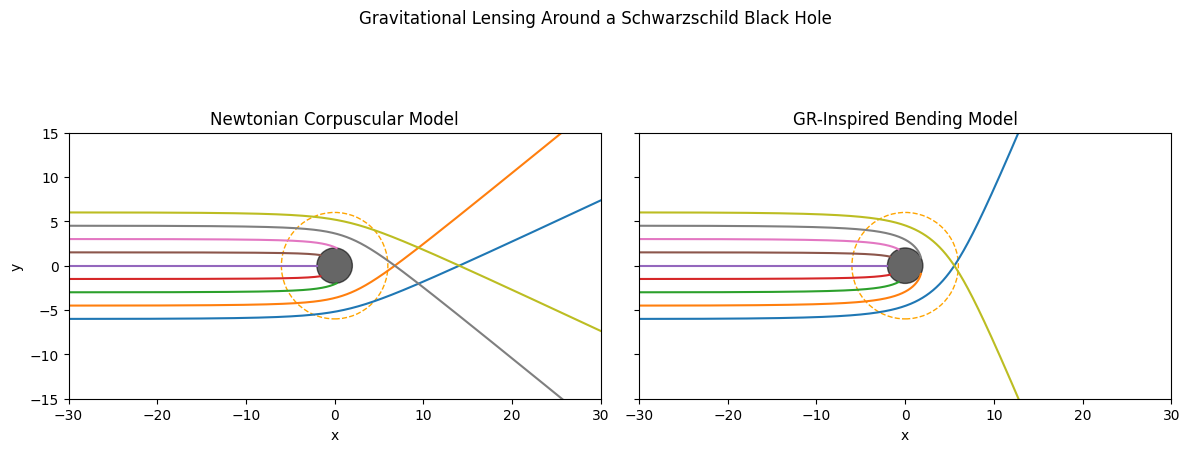

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Physical constants in scaled units (c = G = 1)
M = 1.0  # black hole mass
r_s = 2 * M  # Schwarzschild radius

# Visualization: optional accretion disk reference
disk_radius = 6 * M
show_disk = True

# Ray bundle parameters
num_rays = 9
impact_params = np.linspace(-6, 6, num_rays)  # initial y offsets
x_start = -30.0
y_start = impact_params

# Integration controls
dt_base = 0.05
max_steps = 6000
escape_radius = 40.0

print(f"r_s = {r_s}, disk_radius = {disk_radius}")

def step_size(r, dt0=dt_base, r_s=r_s):
    """Adaptive step size: slow down near the event horizon for stability."""
    if r <= 1.5 * r_s:
        return dt0 * 0.1
    if r <= 3.0 * r_s:
        return dt0 * 0.3
    return dt0

def acceleration(x, y, model="newtonian", M=M):
    r = np.hypot(x, y)
    if r == 0:
        return 0.0, 0.0
    # Newtonian corpuscular model for bending (simple proxy)
    factor = -M / (r**3)
    ax = factor * x
    ay = factor * y
    if model == "gr":
        # GR-inspired amplification to increase bending strength
        ax *= 1.8
        ay *= 1.8
    return ax, ay

def trace_ray(x0, y0, model="newtonian"):
    # Initialize a near-parallel ray moving in +x direction
    x, y = x0, y0
    vx, vy = 1.0, 0.0
    trajectory = [(x, y)]
    for _ in range(max_steps):
        r = np.hypot(x, y)
        if r <= r_s:
            # Collision detection: ray falls into the black hole
            break
        if r >= escape_radius and x > 0:
            break
        dt = step_size(r)
        ax, ay = acceleration(x, y, model=model)
        vx += ax * dt
        vy += ay * dt
        # Normalize speed to keep rays approximately lightlike
        vnorm = np.hypot(vx, vy)
        vx /= vnorm
        vy /= vnorm
        x += vx * dt
        y += vy * dt
        trajectory.append((x, y))
    return np.array(trajectory)

def trace_bundle(model="newtonian"):
    return [trace_ray(x_start, y0, model=model) for y0 in y_start]

newtonian_bundle = trace_bundle(model="newtonian")
gr_bundle = trace_bundle(model="gr")

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, bundle, title in [
    (axes[0], newtonian_bundle, "Newtonian Corpuscular Model"),
    (axes[1], gr_bundle, "GR-Inspired Bending Model"),
]:
    for traj in bundle:
        ax.plot(traj[:, 0], traj[:, 1], linewidth=1.5)
    # Event horizon
    horizon = plt.Circle((0, 0), r_s, color="black", alpha=0.6)
    ax.add_patch(horizon)
    # Optional accretion disk reference
    if show_disk:
        disk = plt.Circle((0, 0), disk_radius, color="orange", fill=False, linestyle="--")
        ax.add_patch(disk)
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-30, 30)
    ax.set_ylim(-15, 15)

axes[0].set_ylabel("y")
plt.suptitle("Gravitational Lensing Around a Schwarzschild Black Hole")
plt.tight_layout()
plt.show()

## Prompts used
1. "Generate a Python notebook that models black hole lensing with simple differential equations and a Matplotlib plot."
2. "Include a short explanation in Markdown and a code cell that traces multiple light rays around a Schwarzschild black hole."